In [1]:
import typing as t

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import collections
import random
import pandas as pd
import numpy as np

# INF554 - Machine and Deep Learning
## Lab 8 - Working with Text, Regularization and Recurrent Neural Networks

In this lab we will be making some *sentiment analysis* with textual data from the IMDB dataset. In its simplest form, the *sentiment analysis* task consists in predicting the polarity of a text as positive or negative.

First of all, let's take a look at the steps of text processing:

1. Tokenization: break sentence into individual words
    - Before: `"PyTorch seems really easy to use!"`
    - After: `["PyTorch", "seems", "really", "easy", "to", "use", "!"]`
2. Building vocabulary: build an index of words associated with unique numbers
    - Before: `["PyTorch", "seems", "really", "easy", "to", "use", "!"]`
    - After: `{"Pytorch: 0, "seems": 1, "really": 2, ...}`
3. Convert to numerals: map words to unique numbers (indices)
    - Before: `{"Pytorch: 0, "seems": 1, "really": 2, ...}`
    - After: `[0, 1, 2, ...]`
4. Embedding look-up: map sentences (indices now) to fixed matrices
    - ```[[0.1, 0.4, 0.3],
       [0.8, 0.1, 0.5],
       ...]```
     

First of all, let's download the IMDB dataset (~85MB) and create the train, test and validation sets:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = pd.read_csv('./data/IMDB Dataset.csv')
data['label']=data['sentiment'].replace(['positive', 'negative'], ['1','0']).astype(int)

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.5, random_state=1337)

train, valid = train_test_split(train, test_size=0.3, random_state=1337)

print(len(train), len(test), len(valid))
train.head()

17500 25000 7500


,review,sentiment,label
39913,Domestic Import was a great movie. I laughed t...,positive,1
13622,Midnight Madness is a movie that is unfortunat...,positive,1
875,Let me first off say that I am a believer of g...,negative,0
38725,I think you would have to be from the USA to g...,positive,1
38077,This is no doubt one of the worst movies I hav...,negative,0


Now we build the *vocabulary* (step 2 above), mapping every word into a numerical id. We consider only the text in the training set for this step. We limit the vocabulary to the 1000 most frequent words.

In [3]:
import torchtext
from torchtext.data import get_tokenizer
from collections import Counter

tokenizer = get_tokenizer("basic_english")

# Build vocabulary
words=[]
num_words = 1000

for text in train['review']:
    tokens=tokenizer(text)
    words.extend(tokens)

top_1k = dict(Counter(words).most_common(1000))
top_1k['<unk>']=num_words+1
top_1k['<pad>']=num_words+2

vocab = torchtext.vocab.vocab(top_1k, specials = ['<unk>', '<pad>']) #if torchtext version 0.13 or higher
#uncomment the following commented lines if you're using torchtext version 0.11
#older versions do not support this way to build a vocabulary
#vocab = torchtext.vocab.vocab(top_1k)
#vocab.append_token('<unk>')
#vocab.append_token('<pad>')
vocab.set_default_index(vocab['<unk>']) #default index used when an unknown words is found

print(vocab.forward(tokenizer(train['review'].iloc[0]))) #example of how a sentence is transformed into a sequence of numerical IDs

[0, 0, 17, 6, 83, 21, 3, 13, 0, 2, 223, 68, 3, 11, 17, 164, 27, 43, 115, 0, 44, 2, 905, 0, 8, 2, 572, 0, 3, 2, 128, 17, 83, 3, 0, 0, 4, 0, 0, 4, 0, 0, 4, 5, 38, 2, 402, 121, 41, 0, 296, 3, 95, 11, 10, 41, 0, 23, 444, 40, 6, 0, 746, 4, 11, 159, 9, 28, 33, 2, 0, 15, 31, 844, 7, 84, 0, 4, 69, 17, 150, 6, 0, 3, 11, 17, 6, 983, 5, 229, 5, 26, 798, 12, 118, 19, 2, 111, 5, 2, 0, 73, 3, 13, 554, 11, 17, 461, 27, 6, 293, 73, 54, 50, 43, 4, 100, 15, 10, 572, 25, 5, 481, 36, 24, 3, 13, 534, 378, 14, 21, 3]


We now transform all reviews to vectors of word IDs. We also need to make all reviews of the same length. We set max_length to 80, therefore we'll cut reviews that exceed 80 words and pad those that are shorter.

In [4]:
max_len=80

def vectorize_sentences(reviews: t.Iterable[str], max_len: int) -> np.ndarray:
    """Converts an iterable of strings into an array encoded from the vocabulary.
    
    Parameters
    ----------
    reviews :
        An iterable containing the sentences (as string) of the datasets
    max_len :
        Sentences are clipped / padded to this maximu number of words
        
    Returns
    -------
    vectorized :
        An array of shape (num_reviews, max_len) containing the dataset.
        Each sentence is encoded to a sequence of integers based on the vocabulary.
    """
    vectors=[]
    for text in reviews:
        tokens=tokenizer(text)
        v=vocab.forward(tokens)
        if len(v) > max_len : v = v[:max_len]
        if len(v) < max_len : #padding
            tmp = np.full(max_len, vocab['<pad>'])
            tmp[0:len(v)]=v 
            v = tmp
        vectors.append(np.array(v))
    return np.array(vectors)


train_X = vectorize_sentences(train['review'], max_len)
test_X = vectorize_sentences(test['review'], max_len)
val_X = vectorize_sentences(valid['review'], max_len)

train_y = np.array(train['label']).reshape(-1,1)
test_y = np.array(test['label']).reshape(-1,1)
val_y = np.array(valid['label']).reshape(-1,1)


Now, we create and load the batches for training. Dataloaders objects incorporate the dataset as tensors, shuffles them automatically, and returns batches of the desired size when called inside a `for` loop during training.

In [5]:
# Define batch size
batch_size = 64

# Create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).float().to(device))
validset = TensorDataset(torch.from_numpy(val_X).to(device), torch.from_numpy(val_y).float().to(device))
testset = TensorDataset(torch.from_numpy(test_X).to(device), torch.from_numpy(test_y).float().to(device))

# Create dataloaders
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(validset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(testset, shuffle=True, batch_size=batch_size)

We introduce now a fully connected NN for text classification

In [6]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, max_len):
        super().__init__()
        self.embedding_dim = embedding_dim
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Linear function
        self.fc1 = nn.Linear(max_len*embedding_dim, hidden_dim) 
        
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        #print("embedding for word ", vocab.lookup_token(42))
        #print(self.embedding(torch.Tensor([42]).int()))
        embedded = embedded.view(-1, max_len*self.embedding_dim)
        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = torch.relu(out)

        # Take note here use a final sigmoid function so your loss should not go through sigmoid again as we are using BCE loss.
        out = self.fc2(out)
        out = torch.sigmoid(out)
    
        return out

In [7]:
input_dim = num_words + 2 #add 2 for start and end sentence symbols
embedding_dim = 100
hidden_dim = 32
output_dim = 1

# Instantiate model class and assign to object
model = FeedforwardNeuralNetModel(input_dim, embedding_dim, hidden_dim, output_dim, max_len)

# Push model to CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function (binary cross-entropy)
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

Natural Language Processing problems are affected by the problem of features that occur infrequently. E.g., it is a lot less likely that we will see the word *phantasmagorical* than the word *reading*. Parameters associated with infrequent features only receive meaningful updates whenever these features occur. Given a decreasing learning rate we might end up in a situation where the parameters for common features converge rather quickly to their optimal values, whereas for infrequent features we are still short of observing them sufficiently frequently before their optimal values can be determined. In other words, the learning rate either decreases too slowly for frequent features or too quickly for infrequent ones.

A solution to this problem are *adaptive learning rates*. For instance, **Adagrad** is an optimization technique based on the accumulation of squared gradients.

Here we use the notation $\mathbf{g}_t = \nabla_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w}))$ for the gradient of the loss function at time $t$. We use the variable $\mathbf{s}_t$ to accumulate past gradient variance.

$$\begin{aligned}
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

However Adagrad has some issues and for our case we are going to use an improved version called <a href="https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html">**RMSprop**</a>. It uses a moving average of squared gradients to normalize the gradient. This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing:

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{w}_t & \leftarrow \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

The constant $\epsilon > 0$ is typically set to $10^{-6}$ to ensure that we do not suffer from division by zero or overly large step sizes. $\gamma$ is usually set to 0.9.

The following block sets up the network with <a href="https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html">Binary Cross Entropy</a> loss and RMSprop optimizer.

In [8]:
def check_model_parameter_sizes(model: torch.nn.Module):
    
    # Number of groups of parameters
    print('Number of groups of parameters {}'.format(len(list(model.parameters()))))
    print('-'*55)
    # Print parameters

    total = 0
    for name, param in model.named_parameters():
        print(f"{name:17} : [{param.numel():6}] {param.size()}")
        total += param.numel()

    print(f"{'TOTAL':17} : [{total:6}]")

    print('-'*55)

In [9]:
check_model_parameter_sizes(model)

Number of groups of parameters 5
-------------------------------------------------------
embedding.weight  : [100200] torch.Size([1002, 100])
fc1.weight        : [256000] torch.Size([32, 8000])
fc1.bias          : [    32] torch.Size([32])
fc2.weight        : [    32] torch.Size([1, 32])
fc2.bias          : [     1] torch.Size([1])
TOTAL             : [356265]
-------------------------------------------------------


The following function carries out the training

In [10]:
def train_model(model, optimizer, loss_criterion):
    iter = 0
    num_epochs = 10
    history_train_acc, history_val_acc, history_train_loss, history_val_loss = [], [], [], []
    best_accuracy = 0
    for epoch in range(num_epochs):
        for i, (samples, labels) in enumerate(train_loader):
            # Training mode
            model.train()

            # Load samples
            samples = samples.view(-1, max_len).to(device)
            labels = labels.view(-1, 1).to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(samples)

            # Calculate Loss: softmax --> cross entropy loss
            loss = loss_criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1

            if iter % 100 == 0:
                # Get training statistics
                train_loss = loss.data.item()

                # Testing mode
                model.eval()
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for samples, labels in valid_loader:
                    # Load samples
                    samples = samples.view(-1, max_len).to(device)
                    labels = labels.view(-1).to(device)

                    # Forward pass only to get logits/output
                    outputs = model(samples)

                    # Val loss
                    val_loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))

                    predicted = outputs.ge(0.5).view(-1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum().item()
                    # correct = (predicted == labels.byte()).int().sum().item()

                accuracy = 100. * correct / total

                # Print Loss
                print(f'Iter: {iter:4} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss.item():2.3f} | Val Accuracy: {accuracy:.2f}')

                # Append to history
                history_val_loss.append(val_loss.data.item())
                history_val_acc.append(round(accuracy, 2))
                history_train_loss.append(train_loss)

                # Save model when accuracy beats best accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    # We can load this best model on the validation set later
                    torch.save(model.state_dict(), 'best_model.pth')
    return (history_train_acc, history_val_acc, history_train_loss, history_val_loss)



This function plots the losses for the testing and validation sets:

In [11]:
def plot_losses(history_train_loss, history_val_loss):
    # Set plotting style
    #plt.style.use(('dark_background', 'bmh'))
    plt.style.use('bmh')
    plt.rc('axes', facecolor='none')
    plt.rc('figure', figsize=(16, 4))

    # Plotting loss graph
    plt.plot(history_train_loss, label='Train')
    plt.plot(history_val_loss, label='Validation')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

Let's observe the behaviour of the model:

In [12]:
(train_acc, val_acc, train_loss, val_loss) = train_model(model, optimizer, criterion)

Iter:  100 | Train Loss: 0.673 | Val Loss: 0.681 | Val Accuracy: 54.60
Iter:  200 | Train Loss: 0.661 | Val Loss: 0.686 | Val Accuracy: 57.80
Iter:  300 | Train Loss: 0.591 | Val Loss: 0.722 | Val Accuracy: 60.24
Iter:  400 | Train Loss: 0.556 | Val Loss: 0.691 | Val Accuracy: 60.96
Iter:  500 | Train Loss: 0.569 | Val Loss: 0.832 | Val Accuracy: 61.41
Iter:  600 | Train Loss: 0.473 | Val Loss: 0.718 | Val Accuracy: 62.63
Iter:  700 | Train Loss: 0.385 | Val Loss: 1.023 | Val Accuracy: 63.15
Iter:  800 | Train Loss: 0.446 | Val Loss: 0.472 | Val Accuracy: 63.59
Iter:  900 | Train Loss: 0.184 | Val Loss: 0.868 | Val Accuracy: 63.83
Iter: 1000 | Train Loss: 0.296 | Val Loss: 1.167 | Val Accuracy: 63.25
Iter: 1100 | Train Loss: 0.173 | Val Loss: 0.490 | Val Accuracy: 63.73
Iter: 1200 | Train Loss: 0.103 | Val Loss: 1.295 | Val Accuracy: 63.72
Iter: 1300 | Train Loss: 0.229 | Val Loss: 1.522 | Val Accuracy: 62.75
Iter: 1400 | Train Loss: 0.047 | Val Loss: 1.245 | Val Accuracy: 64.48
Iter: 

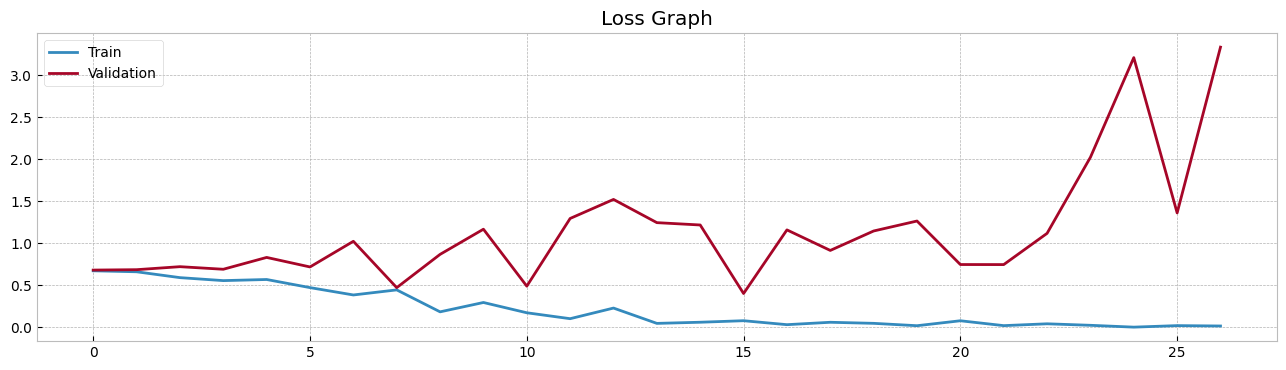

In [13]:
plot_losses(train_loss, val_loss)

> **Ques 1**: What can you deduce from this graph? Is the network working as expected?

Regularization techniques are required to reduce overfitting (i.e. the predictor fits too closely to the training data and does not generalize well to new data). Overfitting tends to occur when we have little data and a complex hypothesis class.

A first idea for regularization is to introduce a *penalty term*, which makes it harder for the optimizer to return an overly flexible predictor.

We will start by adding a regularization term to our (point-wise) loss:

$$ loss_R = loss + \frac{\lambda}{2}\left\Vert W\right\Vert _{2}^{2}$$

The gradient for the regularized loss is therefore:

$$\nabla_W loss_R = \nabla_W loss + \lambda W$$

With pytorch, adding a regularization term is done on the optimization function by adding the parameter *weight_decay* (corresponding to the above $\lambda$) to the call to the optimizer.

> **Task 1**: set the optimizer *weight_decay* to 0.005 and re-train the model, studying its behaviour

You can use the following function to take a look at the parameters of the model before and after regularization:

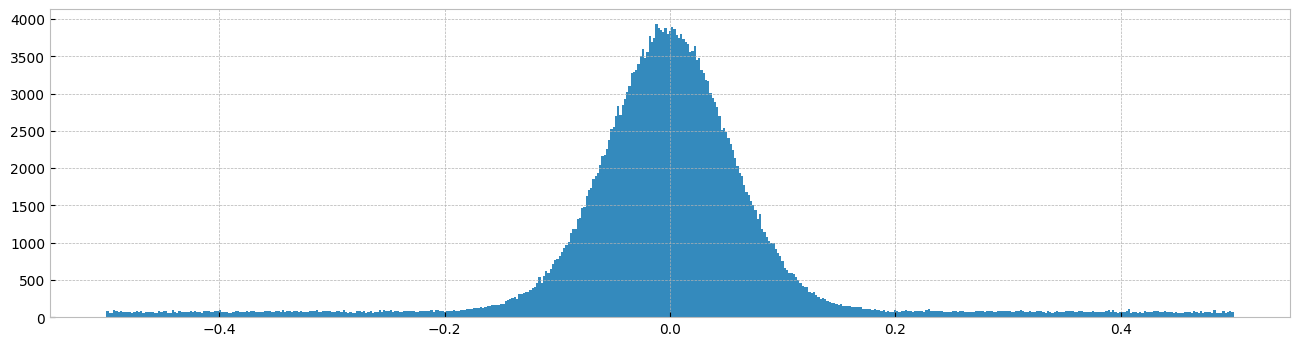

In [14]:
def look_parameters(mdl):
    weights = torch.Tensor().to(device)
    for param_group in list(mdl.parameters()):
        weights = torch.cat((param_group.view(-1), weights))
    ws = weights.detach().cpu().numpy()
    plt.hist(ws.reshape(-1), range=(-.5, .5), bins=501)

look_parameters(model)

In [15]:
# Instantiate model class and assign to object
model = FeedforwardNeuralNetModel(input_dim, embedding_dim, hidden_dim, output_dim, max_len)
model.to(device)

#enter here the code for Task 1
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=0.005)

train_acc, val_acc, train_loss, val_loss = train_model(model, optimizer, criterion)

Iter:  100 | Train Loss: 0.701 | Val Loss: 0.653 | Val Accuracy: 54.88
Iter:  200 | Train Loss: 0.653 | Val Loss: 0.690 | Val Accuracy: 53.44
Iter:  300 | Train Loss: 0.583 | Val Loss: 0.654 | Val Accuracy: 57.52
Iter:  400 | Train Loss: 0.582 | Val Loss: 0.742 | Val Accuracy: 57.52
Iter:  500 | Train Loss: 0.646 | Val Loss: 0.755 | Val Accuracy: 57.39
Iter:  600 | Train Loss: 0.479 | Val Loss: 0.704 | Val Accuracy: 57.64
Iter:  700 | Train Loss: 0.565 | Val Loss: 0.686 | Val Accuracy: 58.45
Iter:  800 | Train Loss: 0.569 | Val Loss: 0.507 | Val Accuracy: 59.07
Iter:  900 | Train Loss: 0.536 | Val Loss: 0.532 | Val Accuracy: 59.24
Iter: 1000 | Train Loss: 0.587 | Val Loss: 0.824 | Val Accuracy: 58.79
Iter: 1100 | Train Loss: 0.447 | Val Loss: 0.713 | Val Accuracy: 59.56
Iter: 1200 | Train Loss: 0.401 | Val Loss: 0.974 | Val Accuracy: 60.60
Iter: 1300 | Train Loss: 0.573 | Val Loss: 0.850 | Val Accuracy: 60.63
Iter: 1400 | Train Loss: 0.374 | Val Loss: 0.492 | Val Accuracy: 61.37
Iter: 

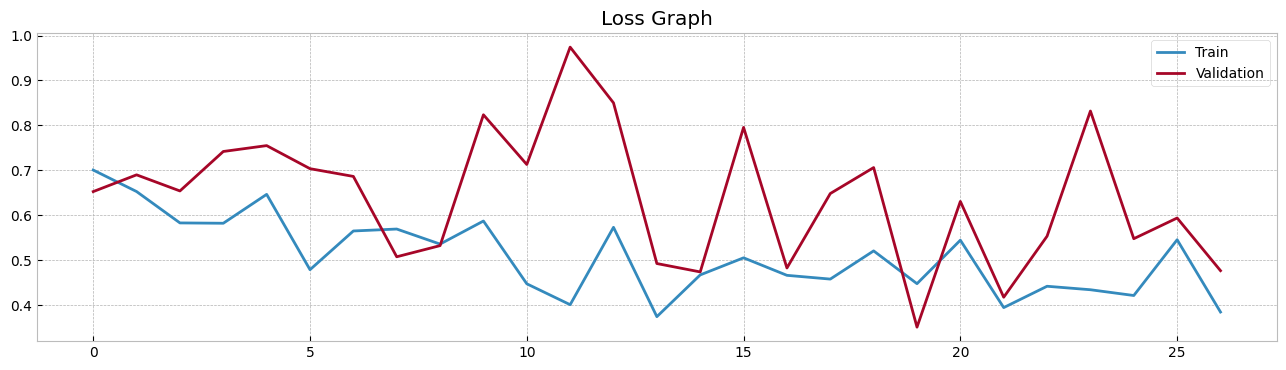

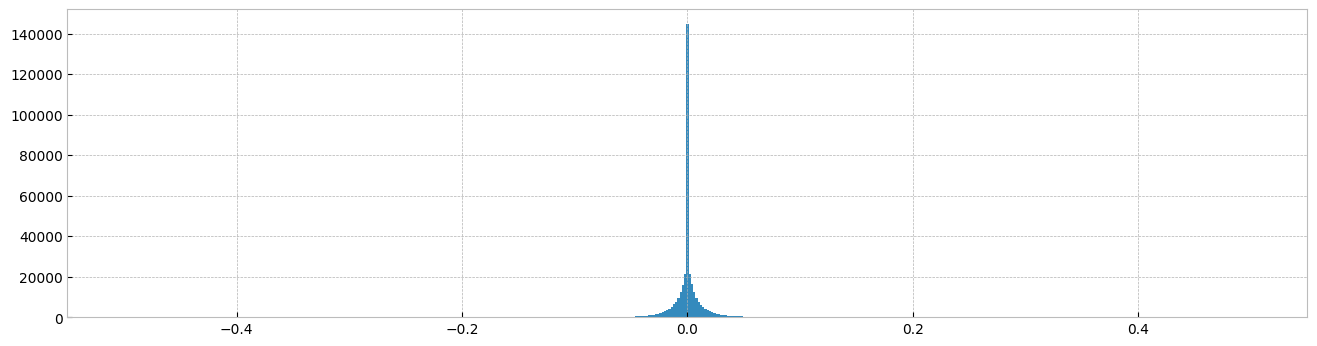

In [16]:
plot_losses(train_loss, val_loss)
look_parameters(model)

## Dropout

Another solution for regularization in neural network consists in applying **Dropout**: at each step of training, a new subnetwork is selected. As a result an adaptation appears in the final network only if it exists in a sufficient part of the training data.

<img src="figures/dropout.png" alt="dropout" width="400"/><font size="1">Image from (Srivastava et al. ,2014) Dropout: A Simple Way to Prevent Neural Networks from
Overfitting, JMLR</font>

We need to introduce a probability $p$ of deactivating a neuron in the hidden layers. So, if we have $n$ neurons in layer $l$, we expect to have $n * (1-p)$ active neurons.

Therefore the output of a generic layer becomes:

$$ z^l = \alpha(W_l^\top \delta z^{l-1} + b_l) $$

with $\delta \sim Bernoulli(p)$ and $\alpha(x)$ an activation function.

> **Task 2** : add <a href="https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html">dropout</a> to the neural network above, between the two fully connected layers, with p=0.8; re-train the new network and observe the result (note: use the optimizer without weight_decay).

In [17]:
class FeedforwardNeuralNetModelWithDropout(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, max_len):
        super(FeedforwardNeuralNetModelWithDropout, self).__init__()
        # Embedding layer
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Linear function
        self.fc1 = nn.Linear(max_len*embedding_dim, hidden_dim) 
        
        #insert here your code
        self.dropout = nn.Dropout(0.8)
        
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        embedded = embedded.view(-1, max_len*self.embedding_dim)
        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = torch.relu(out)
        
        #insert here your code
        out = self.dropout(out)
        
        # Take note here use a final sigmoid function so your loss should not go through sigmoid again as we are using BCE loss.
        out = self.fc2(out)
        out = torch.sigmoid(out)
    
        return out
    

In [18]:
#insert here your code

# Instantiate model class and assign to object
model_dropout= FeedforwardNeuralNetModelWithDropout(input_dim, embedding_dim, hidden_dim, output_dim, max_len)
model_dropout.to(device)

# Optimizer
optimizer = torch.optim.RMSprop(model_dropout.parameters(), lr=1e-3)

(train_acc, val_acc, train_loss, val_loss) = train_model(model_dropout, optimizer, criterion)

Iter:  100 | Train Loss: 0.688 | Val Loss: 0.695 | Val Accuracy: 51.87
Iter:  200 | Train Loss: 0.676 | Val Loss: 0.688 | Val Accuracy: 50.88
Iter:  300 | Train Loss: 0.686 | Val Loss: 0.695 | Val Accuracy: 51.91
Iter:  400 | Train Loss: 0.698 | Val Loss: 0.676 | Val Accuracy: 52.99
Iter:  500 | Train Loss: 0.747 | Val Loss: 0.691 | Val Accuracy: 52.59
Iter:  600 | Train Loss: 0.673 | Val Loss: 0.694 | Val Accuracy: 53.04
Iter:  700 | Train Loss: 0.674 | Val Loss: 0.733 | Val Accuracy: 53.87
Iter:  800 | Train Loss: 0.674 | Val Loss: 0.703 | Val Accuracy: 53.29
Iter:  900 | Train Loss: 0.675 | Val Loss: 0.722 | Val Accuracy: 53.35
Iter: 1000 | Train Loss: 0.672 | Val Loss: 0.689 | Val Accuracy: 54.36
Iter: 1100 | Train Loss: 0.653 | Val Loss: 0.696 | Val Accuracy: 54.29
Iter: 1200 | Train Loss: 0.669 | Val Loss: 0.723 | Val Accuracy: 55.09
Iter: 1300 | Train Loss: 0.685 | Val Loss: 0.676 | Val Accuracy: 55.40
Iter: 1400 | Train Loss: 0.656 | Val Loss: 0.637 | Val Accuracy: 53.49
Iter: 

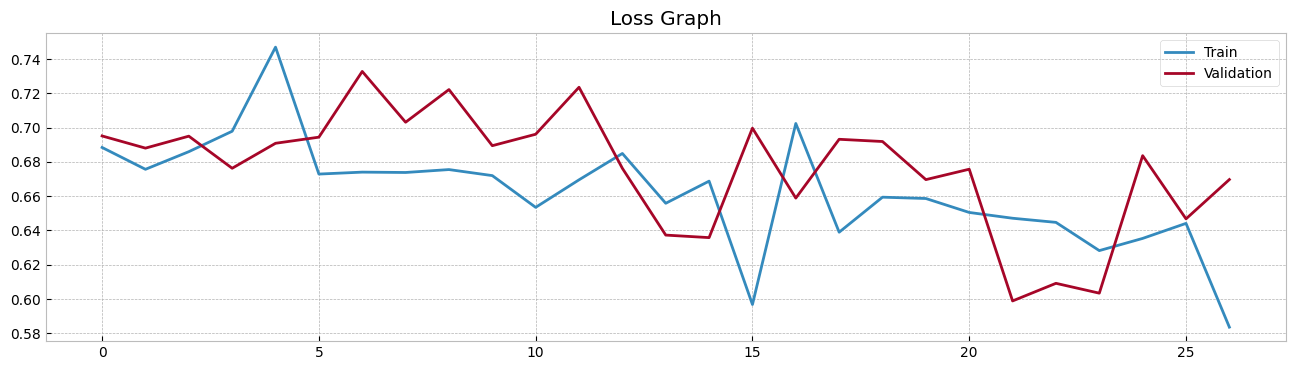

In [19]:
plot_losses(train_loss, val_loss)

## Using LSTM to classify textual data

A fully connected neural network is not an ideal way of processing textual data. Recurrent Neural Networks are more useful for this task since they are more adequate to work on sequential data such as text.

A particular type of RNN is the Long Short-Term Memory, or <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">LSTM</a>.

> **Task 3** : complete the following code to implement a single layer, unidirectional LSTM with a fully connected layer taking the final hidden states of the LSTM as input. Note that you have to set the parameter *batch_first*=True for the LSTM layer as our dataset comes in this format.


In [20]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_class: int):
        """
        Parameters
        ----------
        vocab_size :
            Size of the vocabulary - required by embeddings
        embed_dim :
            Size of embeddings
        hidden_dim :
            Number of hidden units
        num_class :
            Number of classes
        """
        super().__init__()
        self.hidden_dim=hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        #enter here your code
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)
        #SOLUTION task 5
        #self.dropout = nn.Dropout(0.8)
        

    def forward(self, text: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        text :
            Tensor of shape (batch_size, max_len) representing a bag of text tensors
        """
        #ENTER HERE YOUR CODE
        text=self.embedding(text)
        output, (hidden, cell) = self.lstm(text)
        #for the sizes:
        #output:[batch_size, sent_len, hidden_dim*num directions]
        #hidden: [num_layers * num_directions, batch_size, hidden_dim]
        x = hidden.view(-1, self.hidden_dim)
        #SOLUTION task 5
        #x=self.dropout(x)
        x=self.fc(x)
        out = torch.sigmoid(x)
        return out
    
    def get_embedding_for(self, w: str) -> torch.Tensor:
        """Gets the embedding of a word

        Parameters
        ----------
        w :
            String containing a single word
        
        Returns
        -------
        embedding :
            A tensor of shape (embed_dim,) containing the embedding of this word
        """
        idx = vocab.lookup_indices([w])
        with torch.no_grad():
            output = self.embedding(torch.Tensor(idx).int())
        return output

> **Task 4**: run the LSTM model on the IMDB dataset and verify whether it is overfitting or not. 

Iter:  100 | Train Loss: 0.684 | Val Loss: 0.695 | Val Accuracy: 51.87
Iter:  200 | Train Loss: 0.695 | Val Loss: 0.698 | Val Accuracy: 54.19
Iter:  300 | Train Loss: 0.645 | Val Loss: 0.619 | Val Accuracy: 58.65
Iter:  400 | Train Loss: 0.675 | Val Loss: 0.597 | Val Accuracy: 62.48
Iter:  500 | Train Loss: 0.655 | Val Loss: 0.723 | Val Accuracy: 60.84
Iter:  600 | Train Loss: 0.597 | Val Loss: 0.601 | Val Accuracy: 63.67
Iter:  700 | Train Loss: 0.654 | Val Loss: 0.639 | Val Accuracy: 66.19
Iter:  800 | Train Loss: 0.523 | Val Loss: 0.685 | Val Accuracy: 65.27
Iter:  900 | Train Loss: 0.615 | Val Loss: 0.447 | Val Accuracy: 68.76
Iter: 1000 | Train Loss: 0.534 | Val Loss: 0.731 | Val Accuracy: 71.41
Iter: 1100 | Train Loss: 0.436 | Val Loss: 0.757 | Val Accuracy: 72.28
Iter: 1200 | Train Loss: 0.461 | Val Loss: 0.395 | Val Accuracy: 73.37
Iter: 1300 | Train Loss: 0.506 | Val Loss: 0.192 | Val Accuracy: 71.83
Iter: 1400 | Train Loss: 0.585 | Val Loss: 0.580 | Val Accuracy: 73.39
Iter: 

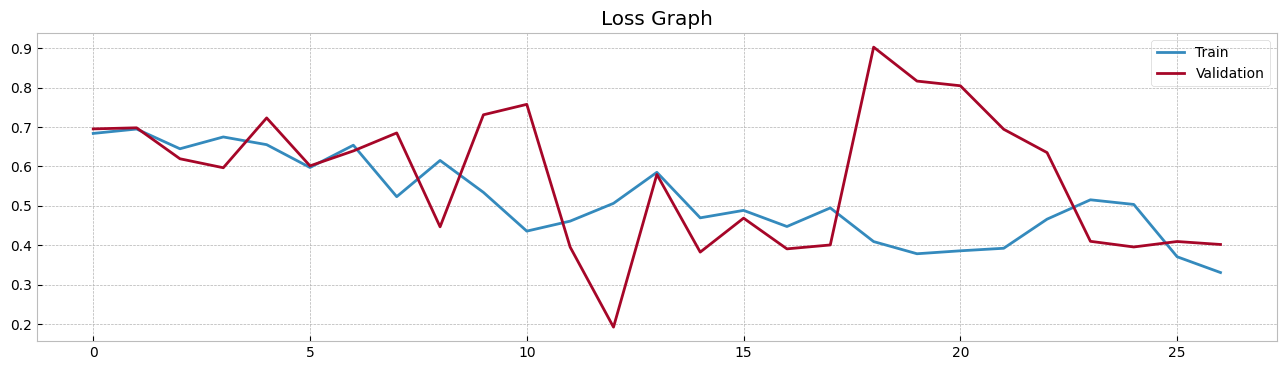

In [21]:
#insert your code here

#Solution Task 4
lstm = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim)
lstm.to(device)

# Optimizer
optimizer = torch.optim.RMSprop(lstm.parameters(), lr=1e-3) #not necessary if the order is respected

(train_acc, val_acc, train_loss, val_loss) = train_model(lstm, optimizer, criterion)
plot_losses(train_loss, val_loss)

> **Task 5**: implement a dropout layer between the LSTM and the fully connected layer 

### A look on the shape of the parameters

In [22]:
check_model_parameter_sizes(lstm)

Number of groups of parameters 7
-------------------------------------------------------
embedding.weight  : [100200] torch.Size([1002, 100])
lstm.weight_ih_l0 : [ 12800] torch.Size([128, 100])
lstm.weight_hh_l0 : [  4096] torch.Size([128, 32])
lstm.bias_ih_l0   : [   128] torch.Size([128])
lstm.bias_hh_l0   : [   128] torch.Size([128])
fc.weight         : [    32] torch.Size([1, 32])
fc.bias           : [     1] torch.Size([1])
TOTAL             : [117385]
-------------------------------------------------------


### A look at Word Embeddings

The word embeddings calculated during training can be extracted from the models and they can be used to calculate a semantic similarity between words.

> **Task 6** : include the following code into the LSTM implementation

```
def get_embedding_for(self, w):
     idx = vocab.lookup_indices([w])
     return self.embedding(torch.Tensor(idx).int())
````
> and test the following block:

you should see that words that are intuitively semantically closer have higher similarity scores (according to cosine similarity)

In [23]:
v1=(lstm.get_embedding_for("great").numpy()).reshape(1,-1)
v2=(lstm.get_embedding_for("bad").numpy()).reshape(1,-1)
v3=(lstm.get_embedding_for("awful").numpy()).reshape(1,-1)

cos_sim = (v1@v2.T/(np.linalg.norm(v1)*np.linalg.norm(v2))).item()
print(f"cosine sim between great and bad:   {cos_sim:+.5f}")

cos_sim = (v2@v3.T/(np.linalg.norm(v2)*np.linalg.norm(v3))).item()
print(f"cosine sim between bad and awful:   {cos_sim:+.5f}")

cos_sim = (v1@v3.T/(np.linalg.norm(v1)*np.linalg.norm(v3))).item()
print(f"cosine sim between great and awful: {cos_sim:+.5f}")

cosine sim between great and bad:   -0.06101
cosine sim between bad and awful:   +0.09023
cosine sim between great and awful: -0.00433
